# Forecasting ⏳🕰️⌚️

John Fiocca

This notebook is a demonstration of a few different forecasting methods on an example data set of airline passengers. The best performing methods were both my own SARIMA model, followed by Holt-Winters Exponential Smoothing. A fully automated Prophet forecast was close to the Exponential smoothing model but still took as much coding as the better performing models. Nevertheless, these automated tools can serve as better baseline models than traditional naïve methods and can be good enough to work as final models for more complicated datasets.

## Setup

Importing required libraries.

In [1]:
from statsmodels.stats.descriptivestats import describe
import kagglehub
import pandas as pd
from prophet import Prophet
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    max_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
)

%matplotlib inline
sns.set_theme()

# Download latest version
path = kagglehub.dataset_download("chirag19/air-passengers")

print("Path to dataset files:", path)

Path to dataset files: /Users/johnfiocca/.cache/kagglehub/datasets/chirag19/air-passengers/versions/1


Loading the example data.

In [2]:
df = pd.read_csv(
    "https://datasets-nixtla.s3.amazonaws.com/air-passengers.csv", parse_dates=["ds"]
)
df.head()

,unique_id,ds,y
0,AirPassengers,1949-01-01,112
1,AirPassengers,1949-02-01,118
2,AirPassengers,1949-03-01,132
3,AirPassengers,1949-04-01,129
4,AirPassengers,1949-05-01,121


Creating a list of scores to use for later validation steps.

In [3]:
scores = [
    mean_absolute_error,
    mean_absolute_percentage_error,
    max_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
]

## Exploratory Data Analysis

Preprocessing the dataframe. Applying a Box-Cox transformation to correct for heteroskedasticity (inconsistent variance). A log transformation is another, less powerful, alternative.

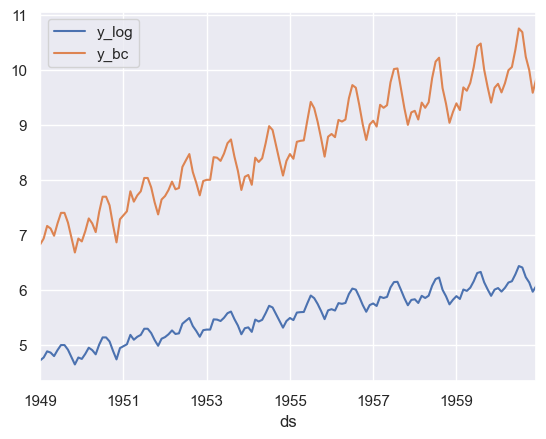

In [4]:
air_passengers = (
    df
    .set_index('ds')
    .asfreq("MS")
    .drop(columns='unique_id')
    .assign(
        y_bc=lambda df: df.y.pipe(boxcox)[0],
        y_bc_lambda=lambda df: df.y.pipe(boxcox)[1],
        y_log=lambda df: df.y.apply('log'),
    )
)

ax = air_passengers[['y_log', 'y_bc']].plot()

Splitting train versus test.

In [5]:
train_size = int(len(air_passengers) * 0.8)
air_passengers_train = air_passengers[:train_size]
air_passengers_test = air_passengers[train_size:]

In [6]:
air_passengers

,y,y_bc,y_bc_lambda,y_log
ds,,,,
1949-01-01,112,6.827488,0.148023,4.718499
1949-02-01,118,6.932820,0.148023,4.770685
1949-03-01,132,7.161889,0.148023,4.882802
1949-04-01,129,7.114609,0.148023,4.859812
1949-05-01,121,6.983785,0.148023,4.795791
...,...,...,...,...
1960-08-01,606,10.684045,0.148023,6.406880
1960-09-01,508,10.234569,0.148023,6.230481
1960-10-01,461,9.992156,0.148023,6.133398


Basic, comprehensive descriptive stats.

In [7]:
from statsmodels.stats.descriptivestats import describe
describe(air_passengers.drop(columns='y_bc_lambda'))

,y,y_bc,y_log
nobs,144.000000,144.000000,144.000000
missing,0.000000,0.000000,0.000000
mean,280.298611,8.621253,5.542176
std_err,9.997193,0.083394,0.036788
upper_ci,299.892749,8.784701,5.614279
lower_ci,260.704473,8.457804,5.470073
std,119.966317,1.000725,0.441456
iqr,180.500000,1.577754,0.694532
iqr_normal,133.804850,1.169591,0.514858
mad,100.442901,0.852887,0.376343


### Seasonal Decomposition

The data contains a linear growth trend with consistent yearly seasonality that increases in variance over time. This calls for seasonal models with transformations or multiplicative seasonality.

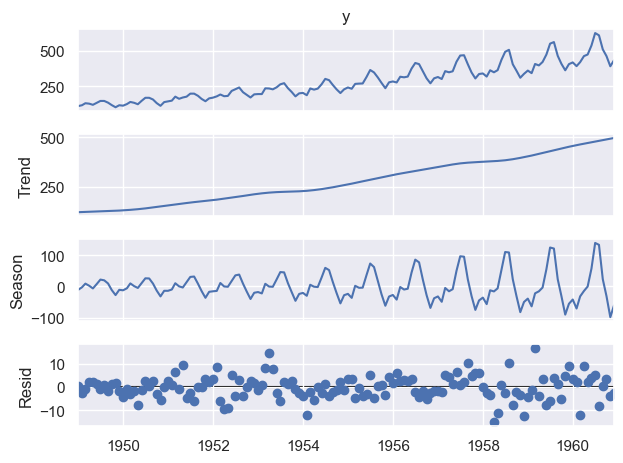

In [8]:
fig = sm.tsa.STL(air_passengers.y).fit().plot().tight_layout()

The ACF plot shows a seasonal length of 12.

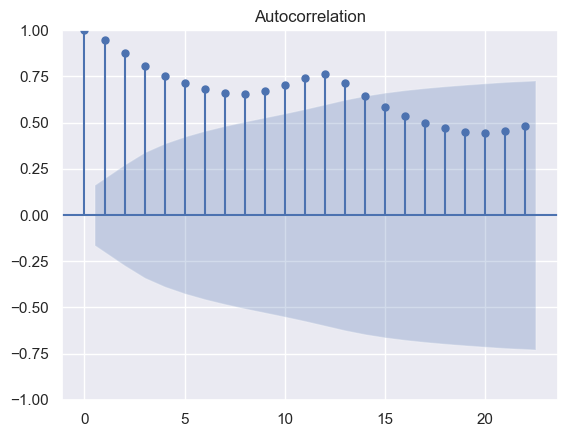

In [9]:
fig = sm.tsa.graphics.plot_acf(air_passengers.y)

The PACF plot shows that the 2 previous values are significantly correlated with each value.

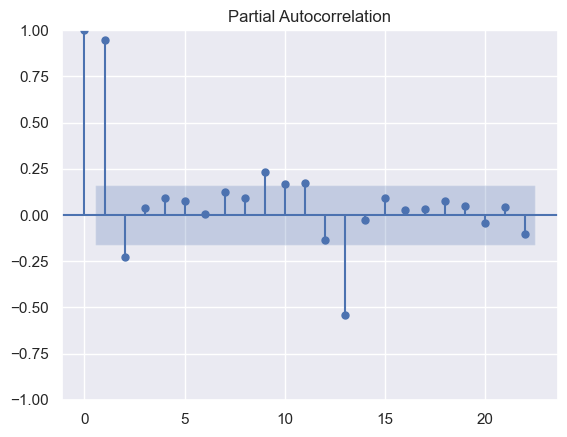

In [10]:
fig = sm.tsa.graphics.plot_pacf(air_passengers.y)

### Interpolation (For Reference)

Given monthly data, we can resample (fill in the values) up to any frequency we like. Here I resample up to a daily level using a polynomial to smooth the values.

                     y      y_bc  y_bc_lambda     y_log
ds                                                     
1949-01-01  112.000000  6.827488     0.148023  4.718499
1949-01-02  111.636811  6.822033     0.148023  4.715872
1949-01-03  111.324102  6.817382     0.148023  4.713636
1949-01-04  111.060490  6.813513     0.148023  4.711781
1949-01-05  110.844592  6.810404     0.148023  4.710297
...                ...       ...          ...       ...
1960-11-27  412.987817  9.720358     0.148023  6.022753
1960-11-28  417.256679  9.745407     0.148023  6.033014
1960-11-29  421.843525  9.772311     0.148023  6.044036
1960-11-30  426.755563  9.801114     0.148023  6.055833
1960-12-01  432.000000  9.831857     0.148023  6.068426

[4353 rows x 4 columns]


<Axes: xlabel='ds'>

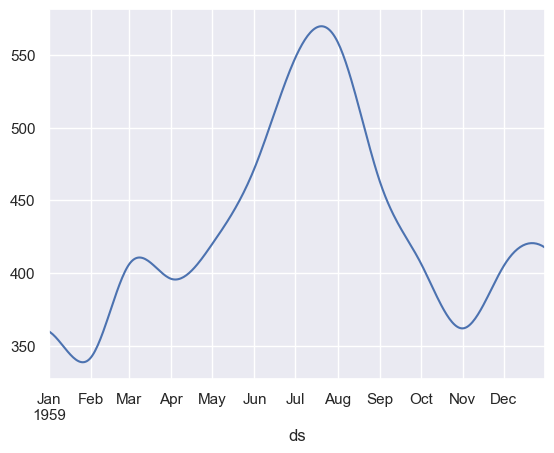

In [11]:
poly_order = 3

rsdf = (
    air_passengers
    .resample('1D')
    # .interpolate()
    .interpolate('polynomial', order=poly_order)
)
print(rsdf)

rsdf.loc['1959'].y.plot()

## Baselines

These baselines must be beat to justify building a custom model.

### Naïve Baselines

Creating a lagged version of the data.

In [12]:
def shifted_frame(shift):

    sf = (
        air_passengers
        .assign(reference_ds=air_passengers.index - pd.DateOffset(months=shift))
        .join(
            air_passengers.shift(shift),
            on='ds',
            how='left',
            rsuffix='_previous'
        )
    )

    return sf

#### Previous Value

Predicting that the next value is equal to the last value.

In [13]:
air_passengers_shifted = shifted_frame(1)
air_passengers_shifted

,y,y_bc,y_bc_lambda,y_log,reference_ds,y_previous,y_bc_previous,y_bc_lambda_previous,y_log_previous
ds,,,,,,,,,
1949-01-01,112,6.827488,0.148023,4.718499,1948-12-01,NaN,NaN,NaN,NaN
1949-02-01,118,6.932820,0.148023,4.770685,1949-01-01,112.0,6.827488,0.148023,4.718499
1949-03-01,132,7.161889,0.148023,4.882802,1949-02-01,118.0,6.932820,0.148023,4.770685
1949-04-01,129,7.114609,0.148023,4.859812,1949-03-01,132.0,7.161889,0.148023,4.882802
1949-05-01,121,6.983785,0.148023,4.795791,1949-04-01,129.0,7.114609,0.148023,4.859812
...,...,...,...,...,...,...,...,...,...
1960-08-01,606,10.684045,0.148023,6.406880,1960-07-01,622.0,10.751448,0.148023,6.432940
1960-09-01,508,10.234569,0.148023,6.230481,1960-08-01,606.0,10.684045,0.148023,6.406880
1960-10-01,461,9.992156,0.148023,6.133398,1960-09-01,508.0,10.234569,0.148023,6.230481


In [14]:
air_passengers_shifted_to_test = air_passengers_shifted.loc[air_passengers_test.index]
air_passengers_shifted_to_test

,y,y_bc,y_bc_lambda,y_log,reference_ds,y_previous,y_bc_previous,y_bc_lambda_previous,y_log_previous
ds,,,,,,,,,
1958-08-01,505,10.219680,0.148023,6.224558,1958-07-01,491.0,10.149183,0.148023,6.196444
1958-09-01,404,9.668136,0.148023,6.001415,1958-08-01,505.0,10.219680,0.148023,6.224558
1958-10-01,359,9.383536,0.148023,5.883322,1958-09-01,404.0,9.668136,0.148023,6.001415
1958-11-01,310,9.036734,0.148023,5.736572,1958-10-01,359.0,9.383536,0.148023,5.883322
1958-12-01,337,9.233164,0.148023,5.820083,1958-11-01,310.0,9.036734,0.148023,5.736572
1959-01-01,360,9.390183,0.148023,5.886104,1958-12-01,337.0,9.233164,0.148023,5.820083
1959-02-01,342,9.268058,0.148023,5.834811,1959-01-01,360.0,9.390183,0.148023,5.886104
1959-03-01,406,9.680146,0.148023,6.006353,1959-02-01,342.0,9.268058,0.148023,5.834811
1959-04-01,396,9.619585,0.148023,5.981414,1959-03-01,406.0,9.680146,0.148023,6.006353


In [15]:
pd.Series({f.__name__: f(air_passengers_shifted_to_test.y, air_passengers_shifted_to_test.y_previous) for f in scores})

mean_absolute_error                 44.724138
mean_absolute_percentage_error       0.102636
max_error                          101.000000
mean_squared_error                2755.344828
root_mean_squared_error             52.491379
r2_score                             0.548636
dtype: float64

#### Previous Year's Value

Predicting that the next value is equal to last year's value.

In [16]:
air_passengers_shifted = shifted_frame(12)
air_passengers_shifted

,y,y_bc,y_bc_lambda,y_log,reference_ds,y_previous,y_bc_previous,y_bc_lambda_previous,y_log_previous
ds,,,,,,,,,
1949-01-01,112,6.827488,0.148023,4.718499,1948-01-01,NaN,NaN,NaN,NaN
1949-02-01,118,6.932820,0.148023,4.770685,1948-02-01,NaN,NaN,NaN,NaN
1949-03-01,132,7.161889,0.148023,4.882802,1948-03-01,NaN,NaN,NaN,NaN
1949-04-01,129,7.114609,0.148023,4.859812,1948-04-01,NaN,NaN,NaN,NaN
1949-05-01,121,6.983785,0.148023,4.795791,1948-05-01,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1960-08-01,606,10.684045,0.148023,6.406880,1959-08-01,559.0,10.476881,0.148023,6.326149
1960-09-01,508,10.234569,0.148023,6.230481,1959-09-01,463.0,10.002891,0.148023,6.137727
1960-10-01,461,9.992156,0.148023,6.133398,1959-10-01,407.0,9.686132,0.148023,6.008813


In [17]:
air_passengers_shifted_to_test = air_passengers_shifted.loc[air_passengers_test.index]
air_passengers_shifted_to_test

,y,y_bc,y_bc_lambda,y_log,reference_ds,y_previous,y_bc_previous,y_bc_lambda_previous,y_log_previous
ds,,,,,,,,,
1958-08-01,505,10.219680,0.148023,6.224558,1957-08-01,467.0,10.024244,0.148023,6.146329
1958-09-01,404,9.668136,0.148023,6.001415,1957-09-01,404.0,9.668136,0.148023,6.001415
1958-10-01,359,9.383536,0.148023,5.883322,1957-10-01,347.0,9.302521,0.148023,5.849325
1958-11-01,310,9.036734,0.148023,5.736572,1957-11-01,305.0,8.998769,0.148023,5.720312
1958-12-01,337,9.233164,0.148023,5.820083,1957-12-01,336.0,9.226132,0.148023,5.817111
1959-01-01,360,9.390183,0.148023,5.886104,1958-01-01,340.0,9.254153,0.148023,5.828946
1959-02-01,342,9.268058,0.148023,5.834811,1958-02-01,318.0,9.096408,0.148023,5.762051
1959-03-01,406,9.680146,0.148023,6.006353,1958-03-01,362.0,9.403429,0.148023,5.891644
1959-04-01,396,9.619585,0.148023,5.981414,1958-04-01,348.0,9.309362,0.148023,5.852202


In [18]:
pd.Series({f.__name__: f(air_passengers_shifted_to_test.y, air_passengers_shifted_to_test.y_previous) for f in scores})

mean_absolute_error                 41.310345
mean_absolute_percentage_error       0.091491
max_error                           74.000000
mean_squared_error                2123.517241
root_mean_squared_error             46.081637
r2_score                             0.652138
dtype: float64

### Prophet

Tools that automate the forecasting process should be considered feasible baselines. This works very well for the raw y's in a multiplicative seasonality mode.

In [19]:
y_train = air_passengers_train.y
y_test = air_passengers_test.y

In [20]:
m = Prophet(
    seasonality_mode='multiplicative',
)

In [21]:
(
    y_train
    .to_frame()
    .reset_index()
    .rename(columns={
        'y_bc': 'y',
    })
).pipe(m.fit)

12:03:34 - cmdstanpy - INFO - Chain [1] start processing
12:03:34 - cmdstanpy - INFO - Chain [1] done processing


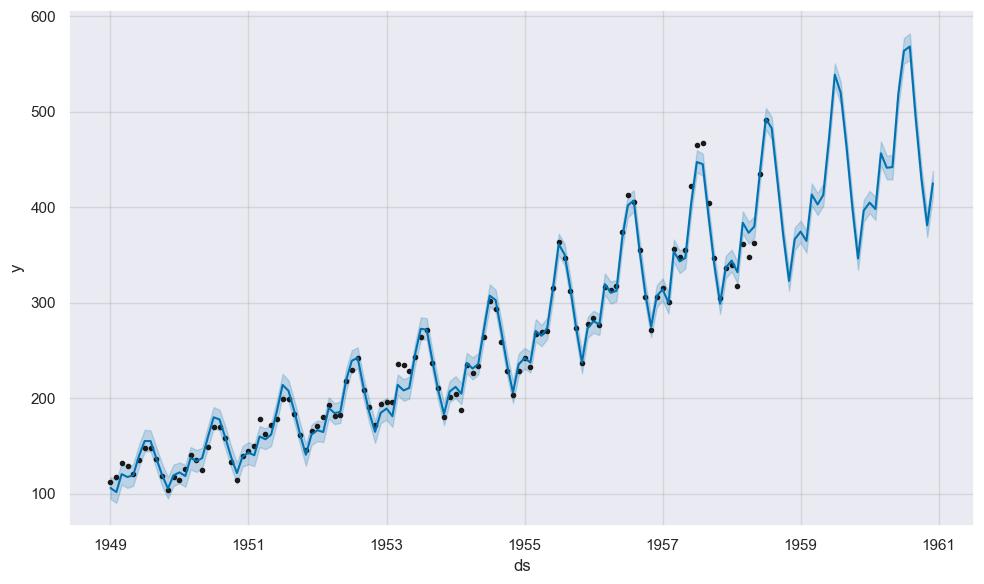

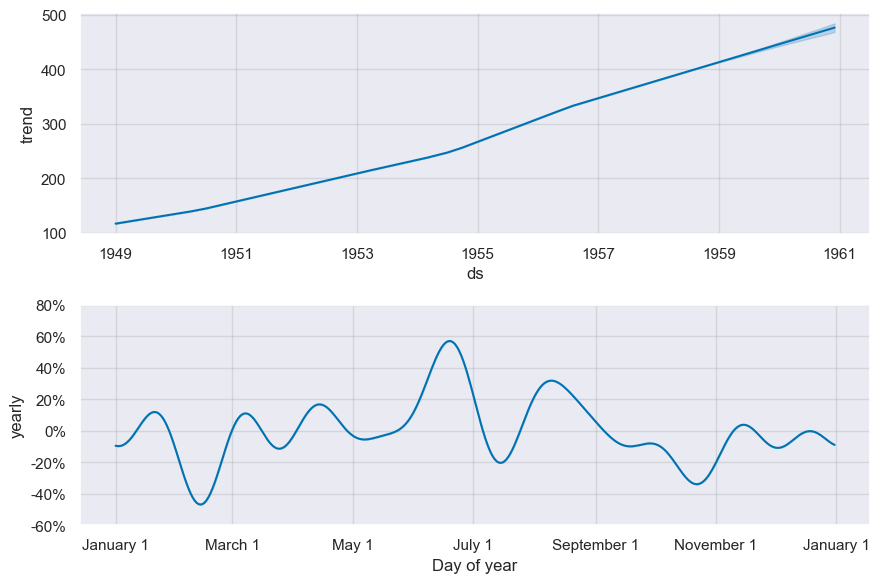

In [22]:
future = m.make_future_dataframe(periods=29, freq='MS')

forecast = m.predict(future)

fig = m.plot(forecast)
fig = m.plot_components(forecast)

In [23]:
prophet_predictions = m.predict(air_passengers_test.reset_index())
prophet_predictions

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1958-08-01,399.007169,471.597213,494.271956,399.003830,399.010905,0.209919,0.209919,0.209919,0.209919,0.209919,0.209919,0.0,0.0,0.0,482.766372
1,1958-09-01,401.807416,416.012832,437.668683,401.741923,401.868036,0.062712,0.062712,0.062712,0.062712,0.062712,0.062712,0.0,0.0,0.0,427.005728
2,1958-10-01,404.517332,360.474579,382.034722,404.356745,404.669967,-0.082766,-0.082766,-0.082766,-0.082766,-0.082766,-0.082766,0.0,0.0,0.0,371.037038
3,1958-11-01,407.317579,312.149185,334.325222,407.041602,407.594551,-0.207256,-0.207256,-0.207256,-0.207256,-0.207256,-0.207256,0.0,0.0,0.0,322.898457
4,1958-12-01,410.027496,355.313573,377.350939,409.595037,410.452281,-0.105912,-0.105912,-0.105912,-0.105912,-0.105912,-0.105912,0.0,0.0,0.0,366.600658
5,1959-01-01,412.827743,362.862245,385.411430,412.206962,413.388937,-0.092992,-0.092992,-0.092992,-0.092992,-0.092992,-0.092992,0.0,0.0,0.0,374.438214
6,1959-02-01,415.627990,354.302930,377.285376,414.830563,416.357038,-0.122359,-0.122359,-0.122359,-0.122359,-0.122359,-0.122359,0.0,0.0,0.0,364.772272
7,1959-03-01,418.157245,401.552994,424.323530,417.092466,419.102917,-0.011560,-0.011560,-0.011560,-0.011560,-0.011560,-0.011560,0.0,0.0,0.0,413.323371
8,1959-04-01,420.957493,391.741821,414.023357,419.682226,422.172998,-0.042773,-0.042773,-0.042773,-0.042773,-0.042773,-0.042773,0.0,0.0,0.0,402.951948
9,1959-05-01,423.667409,401.790276,424.889278,422.131502,425.101885,-0.025387,-0.025387,-0.025387,-0.025387,-0.025387,-0.025387,0.0,0.0,0.0,412.911648


In [24]:
prophet_predictions.join(y_test, on='ds')

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,y
0,1958-08-01,399.007169,471.597213,494.271956,399.003830,399.010905,0.209919,0.209919,0.209919,0.209919,0.209919,0.209919,0.0,0.0,0.0,482.766372,505
1,1958-09-01,401.807416,416.012832,437.668683,401.741923,401.868036,0.062712,0.062712,0.062712,0.062712,0.062712,0.062712,0.0,0.0,0.0,427.005728,404
2,1958-10-01,404.517332,360.474579,382.034722,404.356745,404.669967,-0.082766,-0.082766,-0.082766,-0.082766,-0.082766,-0.082766,0.0,0.0,0.0,371.037038,359
3,1958-11-01,407.317579,312.149185,334.325222,407.041602,407.594551,-0.207256,-0.207256,-0.207256,-0.207256,-0.207256,-0.207256,0.0,0.0,0.0,322.898457,310
4,1958-12-01,410.027496,355.313573,377.350939,409.595037,410.452281,-0.105912,-0.105912,-0.105912,-0.105912,-0.105912,-0.105912,0.0,0.0,0.0,366.600658,337
5,1959-01-01,412.827743,362.862245,385.411430,412.206962,413.388937,-0.092992,-0.092992,-0.092992,-0.092992,-0.092992,-0.092992,0.0,0.0,0.0,374.438214,360
6,1959-02-01,415.627990,354.302930,377.285376,414.830563,416.357038,-0.122359,-0.122359,-0.122359,-0.122359,-0.122359,-0.122359,0.0,0.0,0.0,364.772272,342
7,1959-03-01,418.157245,401.552994,424.323530,417.092466,419.102917,-0.011560,-0.011560,-0.011560,-0.011560,-0.011560,-0.011560,0.0,0.0,0.0,413.323371,406
8,1959-04-01,420.957493,391.741821,414.023357,419.682226,422.172998,-0.042773,-0.042773,-0.042773,-0.042773,-0.042773,-0.042773,0.0,0.0,0.0,402.951948,396
9,1959-05-01,423.667409,401.790276,424.889278,422.131502,425.101885,-0.025387,-0.025387,-0.025387,-0.025387,-0.025387,-0.025387,0.0,0.0,0.0,412.911648,420


In [25]:
pd.Series({f.__name__: f(y_test, prophet_predictions.yhat) for f in scores})

mean_absolute_error                17.854876
mean_absolute_percentage_error      0.039812
max_error                          58.245090
mean_squared_error                492.582025
root_mean_squared_error            22.194189
r2_score                            0.919308
dtype: float64

## Exponential Smoothing

Holt-Winters Exponential Smoothing outperforms a fully-automated Prophet on this data.

In [26]:
y_train = air_passengers_train.y
y_test = air_passengers_test.y

In [27]:
results = (
    air_passengers_train
    .y
    .pipe(
        sm.tsa.ExponentialSmoothing,
        trend='mul',
        seasonal='mul',
        seasonal_periods=12,
        # use_boxcox=True,
    )
    .fit()
)
results.summary()

/Users/johnfiocca/Documents/Developer/venv/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Dep. Variable:,y,No. Observations:,115
Model:,ExponentialSmoothing,SSE,6062.038
Optimized:,True,AIC,487.960
Trend:,Multiplicative,BIC,531.879
Seasonal:,Multiplicative,AICC,495.085
Seasonal Periods:,12,Date:,"Mon, 02 Dec 2024"
Box-Cox:,False,Time:,12:03:34
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9999979,alpha,True
smoothing_trend,4.1932e-10,beta,True


<Axes: xlabel='ds'>

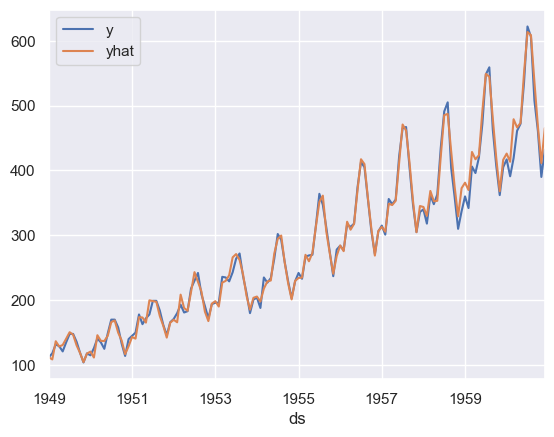

In [28]:
(
    air_passengers
    .assign(
        yhat=(results.predict(min(air_passengers_train.index), max(air_passengers_test.index))))
    .filter(['y', 'yhat'])
    .plot()
)

In [29]:
predictions = results.predict(min(air_passengers_test.index), max(air_passengers_test.index))
pd.Series({f.__name__: f(air_passengers_test.y, predictions) for f in scores})

mean_absolute_error                17.462699
mean_absolute_percentage_error      0.042565
max_error                          59.941083
mean_squared_error                455.269136
root_mean_squared_error            21.337037
r2_score                            0.925421
dtype: float64

## SARIMA

A classic SARIMA is the best model by far for this dataset.

In [30]:
y_train = air_passengers_train.y_bc
y_test = air_passengers_test.y_bc

Note that leaving out a seasonal MA component underpredicts the values. Try it and see the elevated orange dots in the plot.

/Users/johnfiocca/Documents/Developer/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/johnfiocca/Documents/Developer/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                       SARIMAX Results                                       
Dep. Variable:                                  y_bc   No. Observations:                  115
Model:             ARIMA(1, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood                 109.015
Date:                               Mon, 02 Dec 2024   AIC                           -204.031
Time:                                       12:03:35   BIC                           -185.656
Sample:                                   01-01-1949   HQIC                          -196.590
                                        - 07-01-1958                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1851      0.290      0.638      0.524      -0.384       0.754
ma.L1      

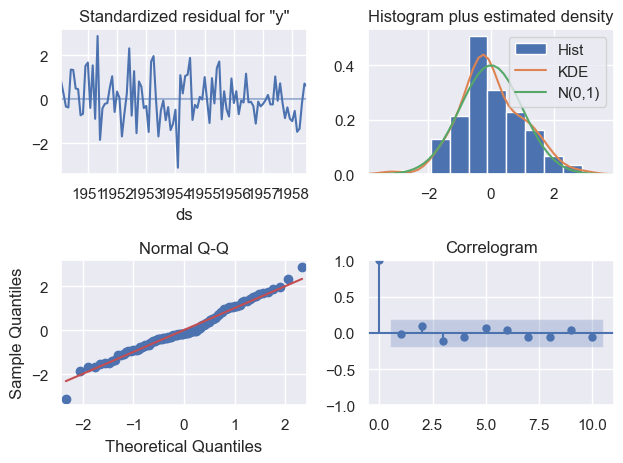

In [31]:
metaparameters = {
    "order": (1, 1, 1),
    "seasonal_order": (2, 1, 2, 12),
}

results = y_train.pipe(sm.tsa.ARIMA, **metaparameters).fit()

# To Read
print(results.summary())
fig = results.plot_diagnostics().tight_layout()

Validation

In [32]:
predictor = results.get_prediction(end=y_test.index[-1])
sf = predictor.summary_frame()
sf_ci80 = predictor.summary_frame(alpha=0.1)

# Just to be clear.
y_hat = sf["mean"].loc[y_test.index]

score_dictionary = {f.__name__: f(y_test, y_hat) for f in scores}
pd.Series(score_dictionary)

mean_absolute_error               0.060934
mean_absolute_percentage_error    0.006195
max_error                         0.145643
mean_squared_error                0.005504
root_mean_squared_error           0.074187
r2_score                          0.969751
dtype: float64

### Show me.

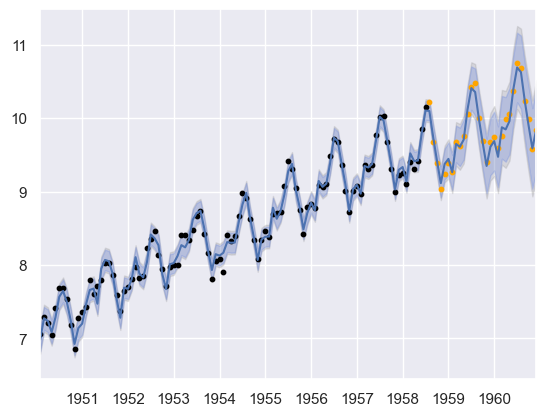

In [33]:
point_size = 10
starting_index = 13

sf[starting_index:]

ax = sf[starting_index:]["mean"].plot()

ax.set_xlim([min(y_train[starting_index:].index), max(y_test.index)])
# ax.set_xlim([min(y_test.index), max(y_test.index)])
# ax.set_xlim([min(y_train[starting_index:].index), max(y_train.index)])

ax.fill_between(
    sf[starting_index:].index,
    sf[starting_index:].mean_ci_lower,
    sf[starting_index:].mean_ci_upper,
    alpha=0.2,
    color="gray",
)

ax.fill_between(
    sf_ci80[starting_index:].index,
    sf_ci80[starting_index:].mean_ci_lower,
    sf_ci80[starting_index:].mean_ci_upper,
    alpha=0.2,
    color="royalblue",
)

ax.scatter(
    y_train.index, y_train, color="black", s=point_size,
)
ax.scatter(
    y_test.index, y_test, color="orange", s=point_size,
)

## Nixtla Statsforecast

Another automated forecast package recommended by the maintainers of Prophet. For this dataset, it's not worth using over a simpler SARIMA. There is likely to be a parameter here to improve the automated accuracy, but for the goal of less code and less cognitive load, the method and the result do not beat more common approaches to this problem.

In [34]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.utils import AirPassengersDF

df = AirPassengersDF
df_train = df[:train_size]
df_test = df[train_size:]

In [35]:
sf = StatsForecast(
    models=[AutoARIMA(season_length=12)],
    freq='MS',
)
sf

StatsForecast(models=[AutoARIMA])

In [36]:
sf.fit(df_train)

StatsForecast(models=[AutoARIMA])

In [37]:
len(df_test)

29

In [38]:
sf_predictions = sf.predict(h=29, level=[95])
sf_predictions

/Users/johnfiocca/Documents/Developer/venv/lib/python3.12/site-packages/statsforecast/core.py:494: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95
unique_id,,,,
1.0,1958-08-01,490.318247,471.354413,509.282082
1.0,1958-09-01,427.871463,403.660225,452.082700
1.0,1958-10-01,370.757341,341.814534,399.700148
1.0,1958-11-01,328.780883,295.857705,361.704060
1.0,1958-12-01,359.776026,323.289533,396.262519
1.0,1959-01-01,363.777028,324.048324,403.505732
1.0,1959-02-01,341.776821,299.050698,384.502945
1.0,1959-03-01,385.776864,340.250346,431.303382
1.0,1959-04-01,371.776855,323.612469,419.941241


In [39]:
pd.Series({f.__name__: f(df_test.y, sf_predictions.AutoARIMA) for f in scores})

mean_absolute_error                 28.567120
mean_absolute_percentage_error       0.061287
max_error                           83.446287
mean_squared_error                1232.215302
root_mean_squared_error             35.102924
r2_score                             0.798146
dtype: float64

/Users/johnfiocca/Documents/Developer/venv/lib/python3.12/site-packages/statsforecast/core.py:1407: FutureWarning: Passing the ids as the index is deprecated. Please provide them as a column instead.
  warnings.warn(


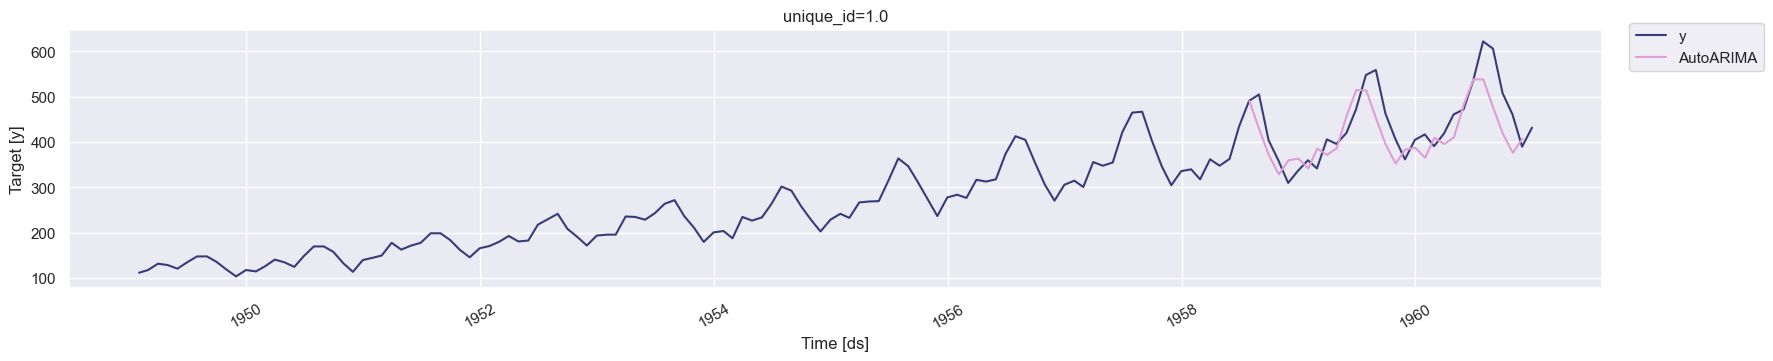

In [40]:
sf.plot(df, forecasts_df=sf_predictions)